# **Assessment 2**
## MTH377 - Convex Optimization
#### Mehar Khurana - 2021541

In [115]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import math
import numdifftools as nd

d1 = 3.5
d2 = 2

## Problem 1

Optimal value: 4.000000000288595


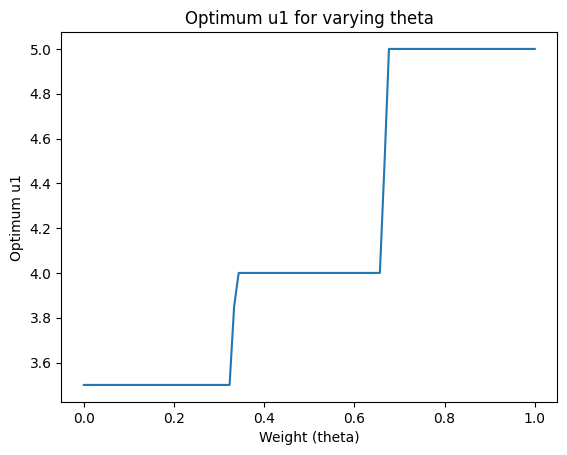

In [116]:
# initialize variables
u1 = cp.Variable()
u2 = cp.Variable()
theta = 0.5

# define constraints
constraints = [u1 >= d1,
               u2 >= d2,
               u1 + 2*u2 <= 12,
               2*u1 + u2 <= 12,]

# define objective function
W = cp.multiply(theta, u1) + u2 - cp.multiply(theta, u2)
obj_func = cp.Maximize(W)

# solve problem
prob = cp.Problem(obj_func, constraints)
prob.solve()

# print results
print("Optimal value:", u2.value)

thetas = np.linspace(0, 1, 100)
u1_lin = np.zeros_like(thetas)

# solve for each theta
for i in range(len(thetas)):
    obj_t = thetas[i] * u1 + (1 - thetas[i]) * u2
    prob_t = cp.Problem(cp.Maximize(obj_t), constraints)
    prob_t.solve()
    u1_lin[i] = u1.value

plt.plot(thetas, u1_lin)
plt.xlabel('Weight (theta)')
plt.ylabel('Optimum u1')
plt.title('Optimum u1 for varying theta')
plt.show()

## Problem 2(a)

In [117]:
# define nash welfare criterion
def nash_welfare(u1, u2):
    return cp.log(u1 - d1) + cp.log(u2 - d2)

# define objective function
W = nash_welfare(u1, u2)
obj_func = cp.Maximize(W)

# solve problem
prob = cp.Problem(obj_func, constraints)
prob.solve()

# print the results
print("Optimal value of u2:", u2.value)
print("Optimal value of u1:", u1.value)

# print primal optimal value
print("Optimal value of Nash welfare:", prob.value)

# print dual variables
for i in range(len(constraints)):
    print("Optimal dual variable for constraint", i, ":", constraints[i].dual_value, "\t[", constraints[i], "]")


Optimal value of u2: 3.500000107723143
Optimal value of u1: 4.249999934442032
Optimal value of Nash welfare: 0.11778302006118169
Optimal dual variable for constraint 0 : 3.2025616584554984e-09 	[ 3.5 <= var208735 ]
Optimal dual variable for constraint 1 : 1.5362047708987957e-09 	[ 2.0 <= var208736 ]
Optimal dual variable for constraint 2 : 3.6166825022595323e-09 	[ var208735 + 2.0 @ var208736 <= 12.0 ]
Optimal dual variable for constraint 3 : 0.6666667551127075 	[ 2.0 @ var208735 + var208736 <= 12.0 ]


## Problem 2(b)

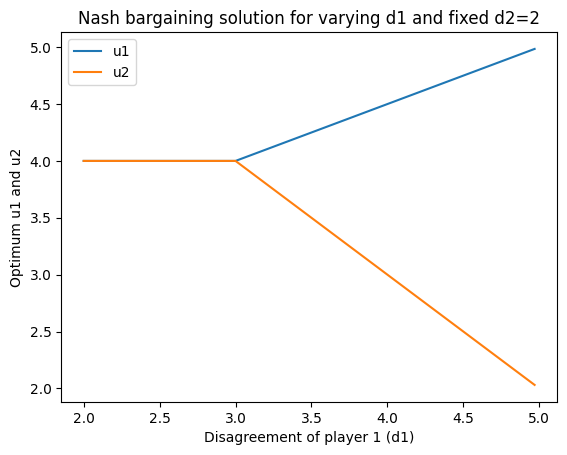

In [118]:
# defining the range of d1
d1_lin = np.linspace(2, 5, 100)

# initialize variables as zeros
u1_opt = np.zeros_like(d1_lin)
u2_opt = np.zeros_like(d1_lin)


# solve over the range of d1
for i in range(len(d1_lin)):
    d1 = d1_lin[i]

    constraints = [u1 >= d1,
                     u2 >= d2,
                        u1 + 2*u2 <= 12,
                        2*u1 + u2 <= 12,]
    W = nash_welfare(u1, u2)
    obj_d = cp.Maximize(W)
    prob_d = cp.Problem(obj_d, constraints)
    prob_d.solve()

    u1_opt[i] = u1.value
    u2_opt[i] = u2.value

# plot the results
plt.plot(d1_lin, u1_opt, label='u1')
plt.plot(d1_lin, u2_opt, label='u2')
plt.xlabel('Disagreement of player 1 (d1)')
plt.ylabel('Optimum u1 and u2')
plt.title('Nash bargaining solution for varying d1 and fixed d2=2')
plt.legend()
plt.show()

## Problem 3

In [119]:
# interior point algorithm without cvxpy

# new disagreement point
d = np.array([2, 1])

# redifining the logarithmic function
def log(x):
    if x > 0:
        return math.log(x)
    else:
        # maximum possible value of log(x) for x <= 0
        return -1e10


# define the objective function (to maximize)
def nash_welfare_new(x):
    return log(x[0] - d[0]) + log(x[1] - d[1])

# function to minimize
def nash_welfare_new_min(x):
    return -1 * nash_welfare_new(x)

# define the constraints
def f1(x):
    return d[0] - x[0]

def f2(x):
    return d[1] - x[1]

def f3(x):
    return x[0] + 2*x[1] - 12

def f4(x):
    return 2*x[0] + x[1] - 12

# expression to minimize, according to interior point algorithm
def f(x, t):
    return t * nash_welfare_new_min(x) - log(-1 * f1(x)) - log(-1 * f2(x)) - log(-1 * f3(x)) - log(-1 * f4(x))


# number of constraints
m = 4

# initialize a random feasible point
X = np.array([3, 3])

# initialize accuracy parameter
t0 = 10
t = t0
print("Initial t = ", t)

# initialize accuracy multiplier
mu = 6

# initialize tolerance
eta_out = 1e-5

while m/t > eta_out:
    # increase accuracy
    t = mu * t

    # run newton descent algorithm
    # initiate X, grad_f and the paramaters alpha, beta and eta
    curr_X = X
    grad_f = nd.Gradient(f)
    eta_in = 0.001
    alpha = 0.3
    beta = 0.6

    # iteration counter for output
    iter = 0

    """ while the length of the grad_f vector is greater than the tolerance eta """
    # print("grad_f = ", grad_f(curr_X, t))
    # print("norm = ", math.sqrt(grad_f(curr_X, t)[0]**2 + grad_f(curr_X, t)[1]**2))
    # print("eta_in = ", eta_in)
    while ( math.sqrt(grad_f(curr_X, t)[0]**2 + grad_f(curr_X, t)[1]**2) > eta_in ):

        # direction vector is initialised to -grad_f by default (Gradient Descent)
        dirn = -1*grad_f(curr_X, t)

        # compute the Hessian
        H = nd.Hessian(f)(curr_X, t)

        # check if all the eigenvalues of the Hessian are positive
        for i in np.linalg.eigvals(H):
            if i <= 0:
                break
                # breaks if a value is non-positive
        else:
            # the direction value is changed to the direction as in Newton Descent
            dirn = np.dot(-1*np.linalg.inv(H), grad_f(curr_X, t))


        # Linear Search
        t_lin = 1000

        # while delta_f is less than -1*alpha*Df(x)(t*direction)
        # Df(x)(t*direction) = transpose(grad_f) . t*direction
        while ( f(curr_X, t) - f(curr_X + t_lin*dirn, t) < -1*alpha*np.dot( np.transpose(grad_f(curr_X, t)), t_lin*dirn ) ):
            # update t
            t_lin = beta * t_lin
            if t_lin < 1e-10:
                break

        # print(f"AT ITERATION {iter}________________________________________________________________________________________")
        # print( f"curr_X :\t\t{curr_X} \t ||grad_f|| : {math.sqrt(grad_f(curr_X, t)[0]**2 + grad_f(curr_X, t)[1]**2)}" )
        # print( f"Direction Derivative : {np.dot( np.transpose(grad_f(curr_X, t)), t_lin*dirn )} \t\t direction vector : {dirn}" )
        # print( f"-del_f : \t\t{f(curr_X, t) - f(curr_X + t_lin*dirn, t)} \t\t t_linear_search (step-size) : {t_lin}\n" )
        
        """ update curr_X """
        curr_X = curr_X + t_lin*dirn

        # print( f"<><><><><><><><><><><> after update, norm of grad_f : {math.sqrt(grad_f(curr_X, t)[0]**2 + grad_f(curr_X, t)[1]**2)} <><><><><><><><><><><><>")
        # print( f"<><><><><><><><><><><> after update, curr_X : {curr_X} <><><><><><><><><><><><>")

        """ increment the counter """
        iter+=1

        if iter > 20:
            break

    # update X
    X = curr_X

print(f"Final t = {t}")
print(f"Nash Bargaining Solution : {X}")
print(f"Maximized value of the objective function : {-1*nash_welfare_new_min(X)}")
# Dual optimal values of the constraints
print(f"Constraint 1 dual optimal value : {-1 / (t*f1(X))} \t [d1 - u1 <= 0]")
print(f"Constraint 2 dual optimal value : {-1 / (t*f2(X))} \t [d2 - u2 <= 0]")
print(f"Constraint 3 dual optimal value : {-1 / (t*f3(X))} \t [u1 + 2u2 - 12 <= 0]")
print(f"Constraint 4 dual optimal value : {-1 / (t*f4(X))} \t [2u1 + u2 - 12 <= 0]")

# inequality constraint values at the optimum:
print(f"Constraint 1 value at optimum : {f1(X)} \t\t [d1 - u1 <= 0]")
print(f"Constraint 2 value at optimum : {f2(X)} \t\t [d2 - u2 <= 0]")
print(f"Constraint 3 value at optimum : {f3(X)} \t\t [u1 + 2u2 - 12 <= 0]")
print(f"Constraint 4 value at optimum : {f4(X)} \t\t [2u1 + u2 - 12 <= 0]")





Initial t =  10
Final t = 466560
Nash Bargaining Solution : [4.02140689 3.95439768]
Maximized value of the objective function : 1.787088545790917
Constraint 1 dual optimal value : 1.0603244035543576e-06 	 [d1 - u1 <= 0]
Constraint 2 dual optimal value : 7.254768262160861e-07 	 [d2 - u2 <= 0]
Constraint 3 dual optimal value : 3.070796408726863e-05 	 [u1 + 2u2 - 12 <= 0]
Constraint 4 dual optimal value : 0.0007686241985696771 	 [2u1 + u2 - 12 <= 0]
Constraint 1 value at optimum : -2.021406886014936 		 [d1 - u1 <= 0]
Constraint 2 value at optimum : -2.954397677915702 		 [d2 - u2 <= 0]
Constraint 3 value at optimum : -0.06979775815366018 		 [u1 + 2u2 - 12 <= 0]
Constraint 4 value at optimum : -0.002788550054425798 		 [2u1 + u2 - 12 <= 0]


## Verifying the value using cvxpy

In [120]:
# use cvxpy to solve the problem
d1 = 2
d2 = 1

# define the variables
u1 = cp.Variable()
u2 = cp.Variable()

# define the constraints
constraints = [u1 >= d1,
                    u2 >= d2,
                    u1 + 2*u2 <= 12,
                    2*u1 + u2 <= 12,]

# define the objective function
W = nash_welfare(u1, u2)

# define the problem
obj = cp.Maximize(W)
prob = cp.Problem(obj, constraints)

# solve the problem
prob.solve()

# print the optimum values
print("u1 = ", u1.value)
print("u2 = ", u2.value)

u1 =  4.0000000049326845
u2 =  3.999999928976241
